#### This notebook looks into the estimated variances for the connectivity weights

In [39]:
import init_paths
import numpy as np
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
import matplotlib.pyplot as plt
from cortico_cereb_connectivity.scripts.script_train_eval_models import *
import matplotlib.pyplot as plt
from scipy import stats

In [41]:
config = rm.get_eval_config(model='ind')
dataset = fdata.get_dataset_class(gl.base_dir,
                                    dataset="MDTB")
config["subj_list"] = dataset.get_participants().participant_id
mu = np.empty((24, 3))
std = np.empty((24, 3))

ext_list = [8]
dirname=[]
mname=[]
for a in ext_list:
    dirname.append(f"MDTB_ses-s1_Icosahedron1002_L2regression")
    if a is None:
        mname.append(f"MDTB_ses-s1_Icosahedron1002_L2regression")
    if isinstance(a,int):
        mname.append(f"MDTB_ses-s1_Icosahedron1002_L2regression_A{a}")
    elif isinstance(a,str):
        mname.append(f"MDTB_ses-s1_Icosahedron1002_L2regression_{a}")

fitted_model,train_info = rm.get_fitted_models(dirname,mname,config)
# Loop over subjects
for i, sub in enumerate(config["subj_list"]):
    YY, info, _ = fdata.get_dataset(gl.base_dir,
                                config["eval_dataset"],
                                atlas=config["cerebellum"],
                                sess=config["eval_ses"],
                                type=config["type"],
                                subj=str(sub))
    XX, info, _ = fdata.get_dataset(gl.base_dir,
                                config["eval_dataset"],
                                atlas=config["cortex"],
                                sess=config["eval_ses"],
                                type=config["type"],
                                subj=str(sub))
    # Average the cortical data over pacels
    X_atlas, _ = at.get_atlas(config['cortex'],gl.atlas_dir)
    # get the vector containing tessel labels
    X_atlas.get_parcel(config['label_img'], unite_struct = False)
    # get the mean across tessels for cortical data
    XX, labels = fdata.agg_parcels(XX, X_atlas.label_vector,fcn=np.nanmean)

    # Remove Nans
    Y = np.nan_to_num(YY[0,:,:])
    X = np.nan_to_num(XX[0,:,:])

    X /= np.sqrt(np.nansum(X ** 2, 0) / X.shape[0])

    # plt.subplots(1, 2, figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.hist(X.flatten(), bins=20)
    mu[i,0], std[i,0] = stats.norm.fit(X.flatten())
    # plt.subplot(1, 2, 2)
    # plt.hist(Y.flatten(), bins=20)
    mu[i,2], std[i,2] = stats.norm.fit(Y.flatten())
    # plt.show()

    # Loop over models
    for j, (fm, tinfo) in enumerate(zip(fitted_model, train_info)):
        
        # Use subject-specific model? (indiv or loo or mix)
        if (isinstance(fm,list)): 
            fitM = fm[i]
        else:
            fitM = fm

        mu[i,1], std[i,1] = stats.norm.fit(fitM.coef_.T.flatten())

In [42]:
for i in range(3):
    print(np.mean(mu[:,i]))
    print(np.mean(std[:,i]**2))

9.192678206739924e-18
1.0
2.460389791221233e-06
1.2178672243049671e-08
-1.4922015445155622e-19
0.005681532169654858


In [43]:
config = rm.get_eval_config()
dataset = fdata.get_dataset_class(gl.base_dir,
                                    dataset="MDTB")
config["subj_list"] = dataset.get_participants().participant_id
fitted_model,train_info = rm.get_fitted_models(dirname,mname,config)

# Loop over models
for j, (fm, tinfo) in enumerate(zip(fitted_model, train_info)):
    fitM = fm
    mu_a, std_a = stats.norm.fit(fitM.coef_.T.flatten())
    print(f'W_mean: {mu_a}')
    print(f'W_var: {std_a**2}')

W_mean: 2.460389791221235e-06
W_var: 1.2864167502419021e-09


In [44]:
print(f'w_ind_var: {np.mean(std[:,1])**2 - std_a**2}')

w_ind_var: 1.0560438620548075e-08


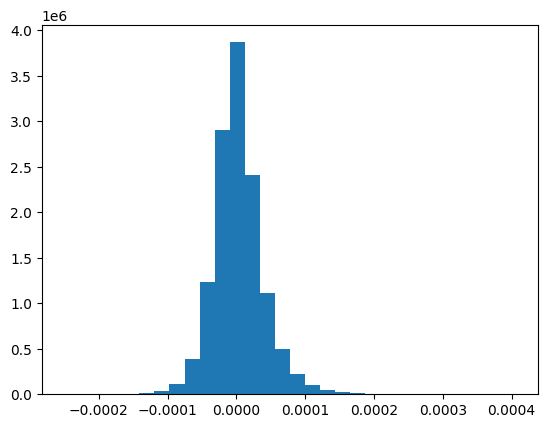

In [45]:
plt.hist(fitM.coef_.T.flatten(), bins=30)
plt.show()